# Final Project – Module 1

### Import packages and datasets that will be used throughout investigation

In [2]:
#--- IMPORT NECESSARY PACKAGES ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf

#--- BASIC GLOBAL DECLARATIONS ---
pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

In [3]:
#--- IMPORT DATA FROM EXTERNAL CSVs ---

# basic title data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# movie basic details from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# wide ranging data from The Movie Database, largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path).drop('Unnamed: 0', axis=1)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

### Aggregate data from various sources to create one cohesive dataframe containing only relevant data

In [4]:
#--- COMBINE AND CLEAN FINANCIAL DATA ---

finance = tn_movie_budgets[['movie', 'production_budget', 
                            'domestic_gross','worldwide_gross']].copy()

# clean data: remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',','')) for x in finance.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in finance.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in finance.worldwide_gross]

# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

In [5]:
#--- CREATE LIST OF ALL POSSIBLE GENRES --- 

# Note: the current formatting shows multiple genres in each 
#       genre cell, separated by commas. The below analysis
#       instead creates a separate column for each genre and
#       represents the data as binary 1 or 0 to indicate whether
#       a given film is classified within that genre

genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []
for genre in genres_messy:
    for genre_split in genre.split(','):
        genres_clean.append(genre_split)
genres_clean = list(set(genres_clean))


df_genres = imdb_title_basics.loc[imdb_title_basics['genres'].isna() == False].copy()
for colname in genres_clean:
    df_genres[colname] = [colname in x for x in df_genres['genres']]

In [6]:
#--- DROP COLUMNS UNWANTED IN FINAL DATAFRAME ---

# Note that this should be kept in a separate cell since running it
# multiple times results in an error if the column is already dropped

imdb_title_basics.drop(['original_title', 'genres'], 
                       axis=1, inplace=True)

tmdb_movies.drop(['original_title', 'id', 'genre_ids', 
                  'original_language'], axis=1, inplace=True)

df_genres.drop(['start_year', 'runtime_minutes', 'genres', 
                'original_title', 'primary_title'], axis=1, inplace=True)

# renaming now makes future SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})


In [7]:
#--- CREATE DATAFRAME THAT AGGREGATES ALL RELEVANT DATA FROM ALL RELEVANT SOURCES ---
q = '''
SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN df_genres USING (tconst);'''

# Use SQL to connect relevant dataframes
all_data = pysqldf(q)

genre_dict = {
'Action': 'genre_action',
'Adult': 'genre_adult',
'Adventure': 'genre_adventure',
'Animation': 'genre_animation',
'Biography': 'genre_biography',
'Comedy': 'genre_comedy',
'Crime': 'genre_crime',
'Documentary': 'genre_documentary',
'Drama': 'genre_drama',
'Family': 'genre_family',
'Fantasy': 'genre_fantasy',
'Game-Show': 'genre_gameshow',
'History': 'genre_history',
'Horror': 'genre_horror',
'Music': 'genre_music',
'Musical': 'genre_musical',
'Mystery': 'genre_mystery',
'News': 'genre_news',
'Reality-TV': 'genre_realitytv',
'Romance': 'genre_romance',
'Sci-Fi': 'genre_scifi',
'Short': 'genre_short',
'Sport': 'genre_sport',
'Talk-Show': 'genre_talkshow',
'Thriller': 'genre_thriller',
'War': 'genre_war',
'Western': 'genre_western',
}

#update column names using above dictionary
col_names = []
for col in all_data.columns:
    if col in genre_dict.keys():
        col_names.append(genre_dict[col])
    else:
        col_names.append(col)
all_data.columns = col_names


# convert "None" values/types to NaN for easier manipulation and consistency
all_data.fillna(value=np.nan, inplace=True) 

## Begin Analysis of Data

In [100]:
# --- AGGREGATE DATA FOR EACH GENRE INTO ONE DATAFRAME ---
GENRES = list(genre_dict.values())
df_genres = pd.DataFrame(genre_dict.keys(), GENRES)
df_genres.reset_index(inplace=True)
df_genres.columns = ['genre_long', 'genre']

In [107]:
# --- START WITH FINANCIALS ---
profit_median = []
profit_mean = []
for genre in GENRES:
    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[genre] == True), 'profit']
    profit_median.append(profit.median())
    profit_mean.append(profit.mean())
    
df_genres['profit_median'] = profit_median
df_genres['profit_mean'] = profit_mean


# --- PROFITABILITY RANK ---
df_genres.sort_values(by='profit_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['profit_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['profit_median'])
# plt.title('Median Profit by Genre ($)')
# plt.show()

In [112]:
# --- POPULARITY ---

popularity_median = []
popularity_mean = []
for genre in GENRES:
    popularity = all_data.loc[(all_data['popularity'].isna() == False) &
                          (all_data[genre] == True), 'popularity']
    popularity_median.append(popularity.median())
    popularity_mean.append(popularity.mean())
    
df_genres['popularity_median'] = popularity_median
df_genres['popularity_mean'] = popularity_mean


# --- POPULARITY RANK ---
df_genres.sort_values(by='popularity_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['popularity_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)

# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['popularity_median'])
# plt.title('Median Popularity by Genre')
# plt.show()

In [114]:
# --- VOTE AVG ---
MIN_VOTE_CT = 0

vote_median = []
vote_mean = []
for genre in GENRES:
    vote = all_data.loc[(all_data['vote_average'].isna() == False) &
                        (all_data['vote_count'] >= MIN_VOTE_CT) &
                          (all_data[genre] == True), 'vote_average']
    vote_median.append(vote.median())
    vote_mean.append(vote.mean())
    
df_genres['vote_median'] = vote_median
df_genres['vote_mean'] = vote_mean

# --- VOTE RANK ---
df_genres.sort_values(by='vote_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['vote_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['vote_median'])
# plt.title('Median Vote by Genre')
# plt.show()

In [116]:
df_genres.sort_values(by='genre')

,genre_long,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,vote_median,vote_mean,vote_rank
19,genre_action,Action,7685268.0,5.307152e+07,14,2.0720,4.095901,11,5.80,5.595508,19
11,genre_adult,Adult,3253717.5,6.474102e+07,19,1.4000,3.712482,19,6.05,6.197475,11
0,genre_adventure,Adventure,57375039.0,1.904184e+08,2,1.8470,3.655558,16,7.80,7.800000,0
26,genre_animation,Animation,17047364.5,1.500886e+08,7,0.9040,2.220196,23,4.55,4.550000,26
21,genre_biography,Biography,4299670.0,4.964393e+07,18,3.9030,3.897000,2,5.60,5.503009,21
25,genre_comedy,Comedy,15275343.5,7.148983e+07,8,2.3790,4.282739,8,5.00,4.861936,25
24,genre_crime,Crime,8462398.0,1.288383e+08,13,0.6970,3.243200,24,5.40,5.348445,24
2,genre_documentary,Documentary,64950630.5,2.922556e+08,1,2.5520,4.599446,6,7.00,6.705348,2
17,genre_drama,Drama,4797192.0,4.173338e+07,17,1.9530,3.630725,14,5.90,5.757830,17
22,genre_family,Family,NaN,NaN,24,4.4065,7.857636,1,5.50,5.279720,22


In [157]:
TOP_CT = 20

tester = df_genres.loc[(df_genres['profit_rank'] <= TOP_CT) & 
              (df_genres['popularity_rank'] <= TOP_CT)]# & 
              #(df_genres['vote_rank'] <= TOP_CT)]

,genre_long,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,vote_median,vote_mean,vote_rank
0,genre_adventure,Adventure,57375039.0,1.904184e+08,2,1.8470,3.655558,16,7.80,7.800000,0
1,genre_realitytv,Reality-TV,14947510.0,4.588240e+07,9,1.4000,3.690759,20,7.00,7.000000,1
2,genre_documentary,Documentary,64950630.5,2.922556e+08,1,2.5520,4.599446,6,7.00,6.705348,2
5,genre_fantasy,Fantasy,2434356.0,3.733343e+07,20,2.3780,5.539034,9,6.60,6.500978,5
8,genre_romance,Romance,25023759.0,1.097484e+08,6,3.7175,6.810780,4,6.40,6.172775,8
10,genre_news,News,28031715.0,2.208677e+07,5,1.9355,4.265355,15,6.20,7.366667,10
11,genre_adult,Adult,3253717.5,6.474102e+07,19,1.4000,3.712482,19,6.05,6.197475,11
13,genre_sport,Sport,85294313.5,1.940365e+08,0,3.7480,6.619390,3,6.00,5.967031,13
15,genre_thriller,Thriller,4856688.0,3.903443e+07,16,2.2130,4.349066,10,6.00,5.944748,15
16,genre_short,Short,36627518.0,1.283730e+08,4,1.6255,3.242104,17,6.00,5.823932,16


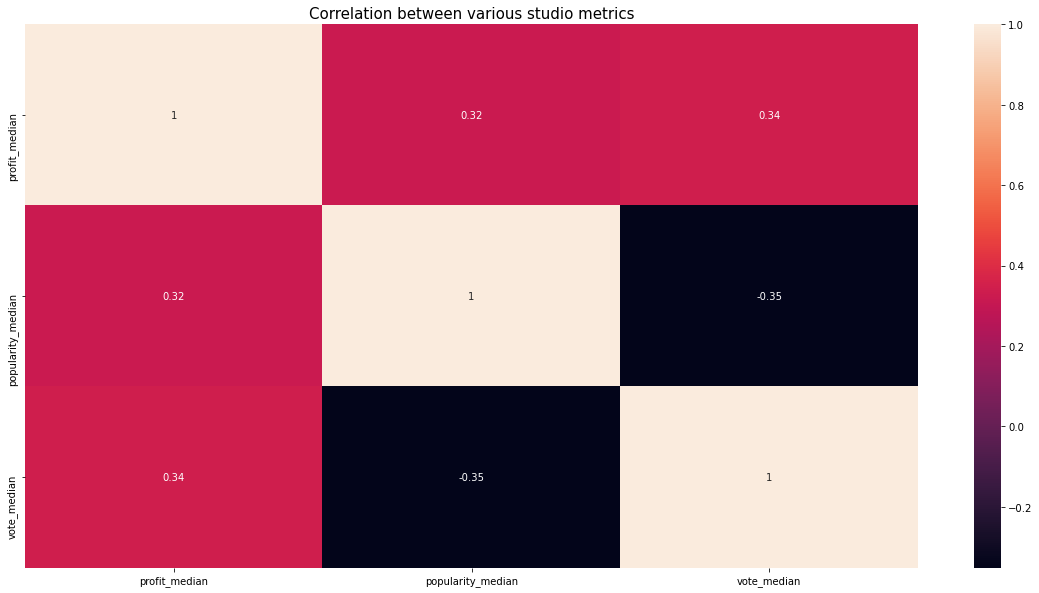

In [158]:
corrMatrix = tester[['profit_median', 'popularity_median', 'vote_median']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between various studio metrics", fontsize=15)
tester

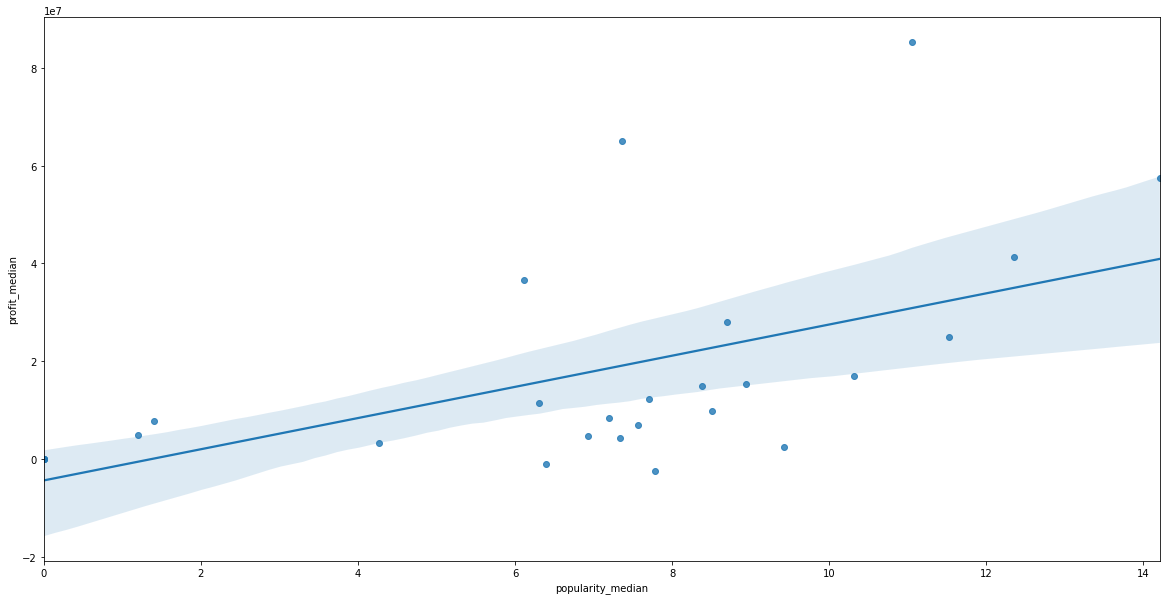

In [159]:
x = df_genre.popularity_median
y = df_genre.profit_median
# use the function regplot to make a scatterplot
sns.regplot(x,y)
plt.show()

# Notes From Call with Joel

- Consider frequency that each genre is produced. 

- Is there anything in this data that says starting with high popularity could lead to later profitability?

- If popularity is so vital, need to define more clearly how that is narrowed. Then, take a look at the most popular movies; profile these aspects to see "what works" and what doesn't

- Consider budgets too since that is especially relevant to companies breaking into a market

- Anything from Runtime?

- Look into top actors -- this could be something they would "need" to have in new films

- Try to create distinction between that the popular and unpopular factors are

- Tell them "what they should care about, and what they shouldn't care about". Second point is less necessary, but can be helpful

- Popular includes number of films produced in that genre, not just ratings

- Also look at distributions of this data, not just median. The company will also care about the confidence interval for these calculations.

# VALUABLE ATTRIBUTES

- median profitability of genre > __
- median popularity of genre > __, as based on imdb ratings. 
    - movies with fewer than __ ratings were excluded
- the genre must have a reasonably large following. this can be proxied by the number of films produced. An appropriate cutoff was determined to be 200 movies. 

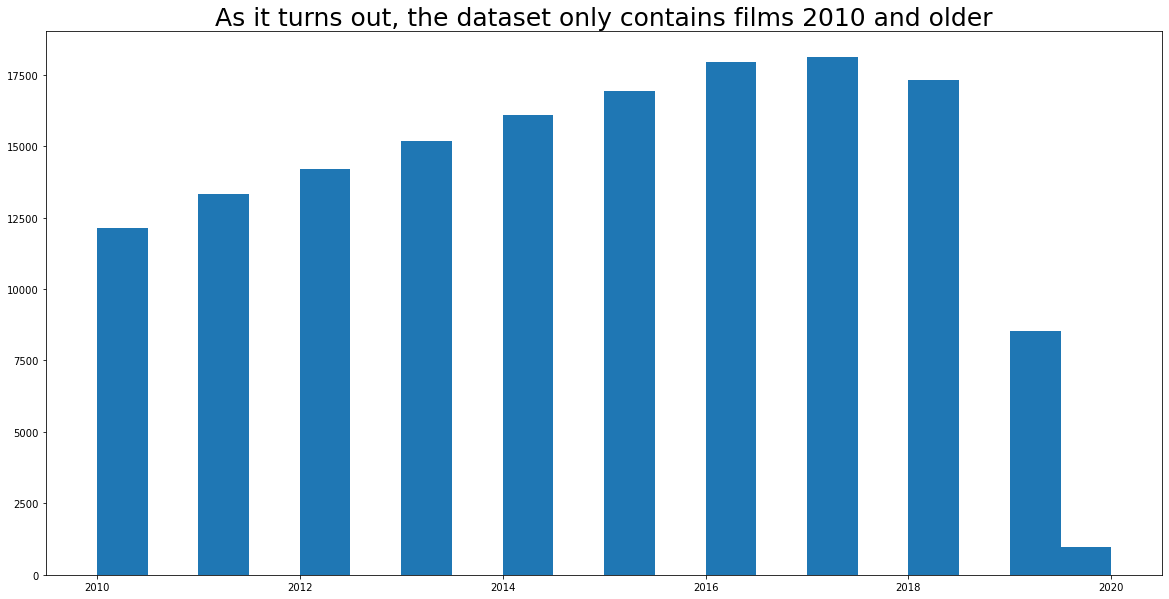

In [161]:
plt.hist(all_data['start_year'].loc[all_data['start_year']<=2020], bins=20)
plt.title('As it turns out, the dataset only contains films 2010 and older', fontsize=25)
plt.show()

#all_data['start_year'].loc[all_data['start_year']<=2020].value_counts()

# GRAPHICS FOR FINAL PRESENTATION: POPULARITY

Create graphs showing the most popular genres



Text(0.5, 1.0, 'Correlation between performance and popularity')

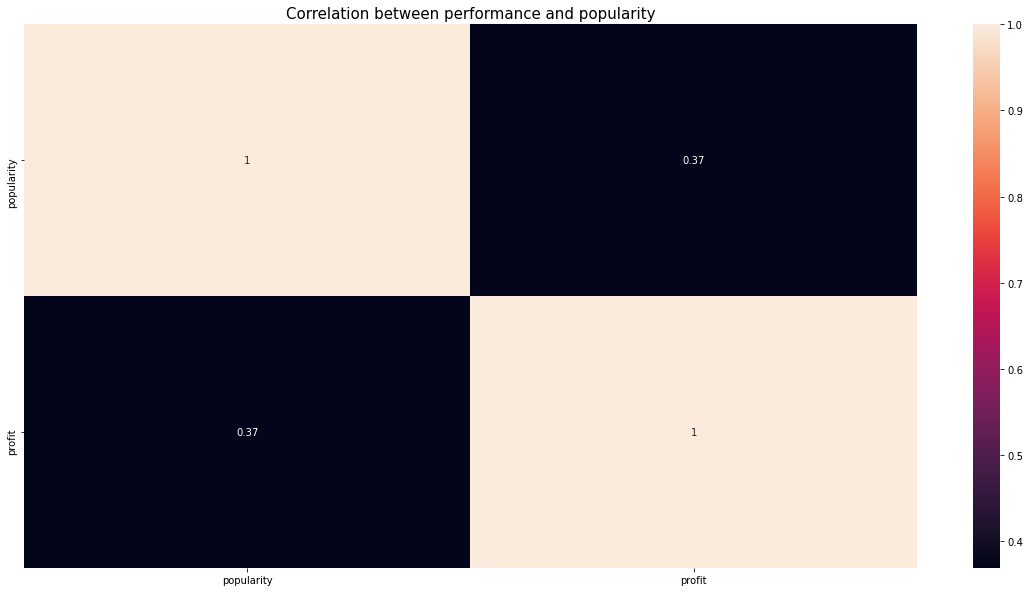

In [162]:
##### DOES POPULARITY LEAD TO PROFITABILITY?

CATEGORY = 'profit'
median = {}
for g in GENRES:
    temp = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data[CATEGORY].isna() == False) &
                        (all_data[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_profit = pd.DataFrame(median.items())


CATEGORY = 'popularity'
median = {}
for g in GENRES:
    temp = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data[CATEGORY].isna() == False) &
                        (all_data[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_popularity = pd.DataFrame(median.items())


q = '''SELECT * FROM df_profit JOIN df_popularity USING ('0');'''
df = pysqldf(q)
df.columns = ['genre', 'profit', 'popularity']


df = all_data[['tconst', 'profit', 'popularity']].dropna().reset_index(drop=True)
QUANTILE = 0.01
df = df.loc[(df.profit >= df.profit.quantile(QUANTILE)) & (df.profit <= df.profit.quantile(1-QUANTILE))].copy()
df = df.loc[(df.popularity >= df.popularity.quantile(QUANTILE)) & (df.popularity <= df.popularity.quantile(1-QUANTILE))].copy()

x = df.popularity
y = df.profit
# use the function regplot to make a scatterplot
sns.regplot(x,y)
#sns.plt.show()
 
# Without regression fit:
#sns.regplot(x=df["sepal_length"], y=df["sepal_width"], fit_reg=False)
#sns.plt.show()


corrMatrix = df[['popularity', 'profit']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between performance and popularity", fontsize=15)

In [ ]:
df_profit